In [1442]:
from music21 import *

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [1443]:
# get bach paths
paths = corpus.getComposer('bach')

# get n pieces
paths = paths[:50]

# get all the notes of the first part of each piece
notes = []
midi_notes = []
for path in paths:
    score = converter.parse(paths[0])

    # get the first part
    part = score.parts[0]

    # get all notes from the part
    notes.extend(list(map(lambda note: note, part.recurse().notes)))

midi_notes = list(map(lambda note: note.pitch.midi, notes))

print(f'len(notes): {len(notes)}')
print(f'len(midi_notes): {len(midi_notes)}')
print(midi_notes)

len(notes): 7650
len(midi_notes): 7650
[65, 67, 60, 65, 53, 57, 53, 57, 60, 65, 70, 69, 67, 65, 67, 69, 69, 65, 67, 69, 70, 72, 70, 69, 67, 67, 72, 72, 71, 69, 71, 72, 65, 65, 70, 69, 67, 65, 60, 65, 60, 60, 57, 53, 60, 60, 60, 57, 65, 67, 60, 65, 53, 57, 53, 57, 60, 65, 70, 69, 67, 65, 67, 69, 69, 65, 67, 69, 70, 72, 70, 69, 67, 67, 72, 72, 71, 69, 71, 72, 65, 65, 70, 69, 67, 65, 60, 65, 60, 60, 57, 53, 60, 60, 60, 57, 67, 60, 60, 60, 60, 60, 60, 65, 67, 65, 67, 69, 67, 65, 65, 60, 65, 60, 72, 70, 69, 70, 72, 70, 69, 67, 65, 60, 72, 60, 67, 65, 64, 65, 65, 53, 60, 60, 60, 57, 69, 67, 69, 70, 72, 72, 70, 69, 69, 67, 65, 65, 53, 60, 60, 60, 57, 65, 67, 60, 65, 53, 57, 53, 57, 60, 65, 70, 69, 67, 65, 67, 69, 69, 65, 67, 69, 70, 72, 70, 69, 67, 67, 72, 72, 71, 69, 71, 72, 65, 65, 70, 69, 67, 65, 60, 65, 60, 60, 57, 53, 60, 60, 60, 57, 65, 67, 60, 65, 53, 57, 53, 57, 60, 65, 70, 69, 67, 65, 67, 69, 69, 65, 67, 69, 70, 72, 70, 69, 67, 67, 72, 72, 71, 69, 71, 72, 65, 65, 70, 69, 67, 65, 60, 

In [1444]:
# turn notes in to training sequences of 5
# map each sequence to note that follows
# [65, 67, 60, 65, 53] -> 57
# [67, 60, 65, 53, 57] -> 53

# set the length of the sequence that predicts the next note
seq_length = 5

print(f'len(midi_notes): {len(midi_notes)}')

data = []
labels = []
for i in range(len(midi_notes)):
    seq_end = i + seq_length
    
    if seq_end >= len(midi_notes): break
    
#     print(f'i: {i}')
#     print(f'seq_end: {seq_end}')
    
    seq = midi_notes[i:seq_end]        
    data.append(seq)
    labels.append(midi_notes[seq_end])

print(f'data:\n{data[:3]}')
print(f'labels:\n{labels[:3]}')

len(midi_notes): 7650
data:
[[65, 67, 60, 65, 53], [67, 60, 65, 53, 57], [60, 65, 53, 57, 53]]
labels:
[57, 53, 57]


In [1445]:
# # normalize
# from sklearn.preprocessing import MinMaxScaler

# scaler_data = MinMaxScaler(feature_range=(0, 1))
# scaler_data = scaler.fit(data)
# data_norm = scaler_data.transform(data)

# scaler_labels = MinMaxScaler(feature_range=(0, 1))
# scaler_labels = scaler.fit(labels)
# labels_norm = scaler_labels.transform(labels)

# print(data_norm.shape)
# print(labels_norm.shape)

# for i, seq in enumerate(data_norm):
#     print(f'{seq} -> {labels_norm[i]}')

In [1446]:
# get the data in shape
data = np.array(data, dtype=float)
data = data.reshape(-1, seq_length, 1)

labels = np.array(labels, dtype=float)
labels = labels.reshape(-1, 1)

# normalise
data = data / 128
labels = labels / 128

print(data.shape)
print(labels.shape)

# for i, seq in enumerate(data):
#     print(f'{seq} -> {labels[i]}')

(7645, 5, 1)
(7645, 1)


In [1447]:
# get test and train data

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=4)

In [1448]:
# build the model

model = Sequential()
model.add(LSTM((512), batch_input_shape=(None, seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM((256), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM((128), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM((1), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))


In [1449]:
# compile the model

model.compile(loss='mse', optimizer='adam')
print(model.input_shape)
print(model.output_shape)
print(model.summary())

(None, 5, 1)
(None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_279 (LSTM)              (None, 5, 512)            1052672   
_________________________________________________________________
dropout_143 (Dropout)        (None, 5, 512)            0         
_________________________________________________________________
lstm_280 (LSTM)              (None, 5, 256)            787456    
_________________________________________________________________
dropout_144 (Dropout)        (None, 5, 256)            0         
_________________________________________________________________
lstm_281 (LSTM)              (None, 5, 128)            197120    
_________________________________________________________________
dropout_145 (Dropout)        (None, 5, 128)            0         
_________________________________________________________________
lstm_282 (LSTM)              (None, 1)               

In [1450]:
# checkpoint

filepath="weights-improvement-{epoch:02d}-{val_loss:.10f}.hdf5"
#checkpoint = EarlyStopping(monitor='val_loss', mode='auto', patience=5, verbose=1, restore_best_weights=True )
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

callbacks_list = [checkpoint]

In [1451]:
# fit the model

history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks_list)

Train on 6116 samples, validate on 1529 samples
Epoch 1/100
6116/6116 [==============================] - 38s 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 2/100
6116/6116 [==============================] - 10s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3/100
6116/6116 [==============================] - 10s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4/100
6116/6116 [==============================] - 10s 2ms/step - loss: 0.0011 - val_loss: 9.5383e-04
Epoch 5/100
6116/6116 [==============================] - 10s 2ms/step - loss: 9.9420e-04 - val_loss: 8.3298e-04
Epoch 6/100
6116/6116 [==============================] - 10s 2ms/step - loss: 8.9384e-04 - val_loss: 8.1190e-04
Epoch 7/100
6116/6116 [==============================] - 10s 2ms/step - loss: 9.0604e-04 - val_loss: 7.5173e-04
Epoch 8/100
6116/6116 [==============================] - 10s 2ms/step - loss: 8.8047e-04 - val_loss: 7.8113e-04
Epoch 9/100
6116/6116 [==============================] - 10s 2ms/step - loss: 8.3219

6116/6116 [==============================] - 10s 2ms/step - loss: 1.7121e-04 - val_loss: 1.0927e-04
Epoch 74/100
6116/6116 [==============================] - 10s 2ms/step - loss: 1.5406e-04 - val_loss: 1.2635e-04
Epoch 75/100
6116/6116 [==============================] - 10s 2ms/step - loss: 1.2552e-04 - val_loss: 8.8690e-05
Epoch 76/100
6116/6116 [==============================] - 10s 2ms/step - loss: 1.6412e-04 - val_loss: 9.7425e-05
Epoch 77/100
6116/6116 [==============================] - 10s 2ms/step - loss: 1.6423e-04 - val_loss: 1.3938e-04
Epoch 78/100
6116/6116 [==============================] - 10s 2ms/step - loss: 1.6023e-04 - val_loss: 1.0538e-04
Epoch 79/100
6116/6116 [==============================] - 10s 2ms/step - loss: 1.6102e-04 - val_loss: 9.0963e-05
Epoch 80/100
6116/6116 [==============================] - 10s 2ms/step - loss: 1.3131e-04 - val_loss: 9.1340e-05
Epoch 81/100
6116/6116 [==============================] - 10s 2ms/step - loss: 1.2219e-04 - val_loss: 8.1980e

In [1452]:
# get the score

score = model.evaluate(x_test, y_test, batch_size=64)
print(score)

1529/1529 [==============================] - 1s 421us/step
7.745046608454254e-05


In [1453]:
# predict y_test

results= model.predict(x_test)
# results = results * 128
# y_test = y_test * 128
# print(f'results:\n{results}')
# print(f'y_test:\n{y_test}')

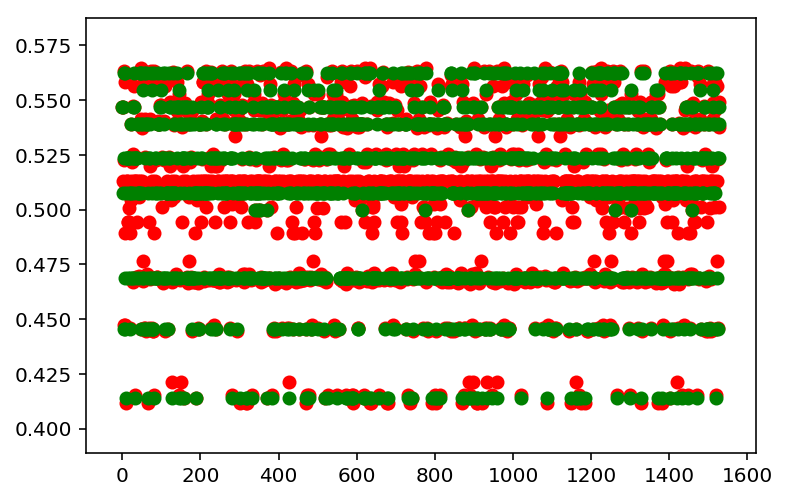

In [1454]:
plt.scatter(range(len(results)), results, c='r')
plt.scatter(range(len(y_test)), y_test, c='g')

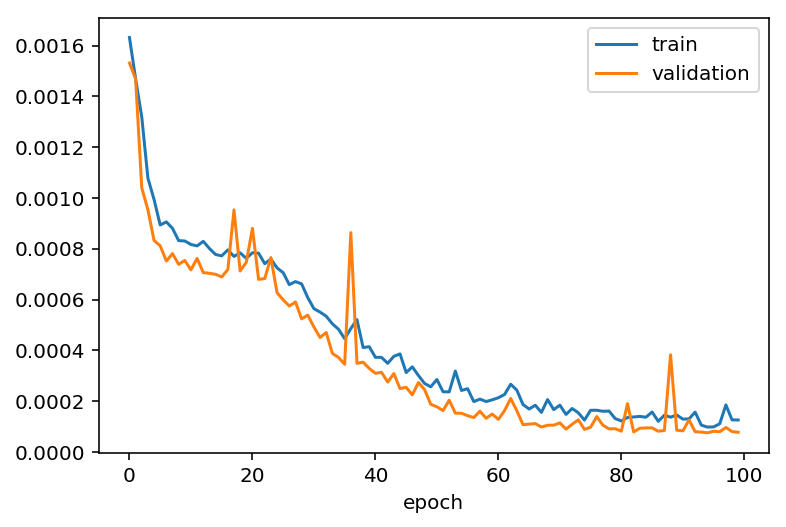

In [1455]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [1457]:
# load best weights

model.load_weights('weights-improvement-95-0.0000753107.hdf5')

score = model.evaluate(x_test, y_test, batch_size=64)
print(score)

1529/1529 [==============================] - 1s 383us/step
7.531069108769096e-05
